# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from IPython.display import display # Allows the use of display() for DataFrames
from sklearn.preprocessing import Imputer #handles missing values in dataset
from sklearn.base import TransformerMixin #provides default implementation of fit_transform
from sklearn.preprocessing import StandardScaler  #standardizes features in dataset
from sklearn.decomposition import PCA #transfroms high-dimensional dataset into lower-dimension
from sklearn.cluster import KMeans #partition dataset into user defined number (K) of clusters
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# to be able to see all columns
pd.set_option('display.max_columns', None)
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep = ';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep = ';')

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
print(azdias.shape)

(891221, 85)


In [4]:
print(azdias.head())

   AGER_TYP  ALTERSKATEGORIE_GROB  ANREDE_KZ  CJT_GESAMTTYP  \
0        -1                     2          1            2.0   
1        -1                     1          2            5.0   
2        -1                     3          2            3.0   
3         2                     4          2            2.0   
4        -1                     3          1            5.0   

   FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  \
0                  3              4                 3               5   
1                  1              5                 2               5   
2                  1              4                 1               2   
3                  4              2                 5               2   
4                  4              3                 4               1   

   FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER  FINANZTYP  GEBURTSJAHR  \
0                      5                 3          4            0   
1                      4                 5

In [5]:
display (azdias.head ())

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,4,0,10.0,0,-1,15.0,4.0,2.0,2.0,1.0,1.0,0,0,5.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,-1,NaN,NaN,-1,3,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,1,1996,10.0,0,3,21.0,6.0,5.0,3.0,2.0,1.0,1,14,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,3,1.0,0.0,2,5,0.0,2.0,0.0,6.0,NaN,3.0,9.0,11.0,0.0,8.0,1.0,1992.0,W,4.0,8,8A,51,0.0,0.0,0.0,2.0,5.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,1,1979,10.0,1,3,3.0,1.0,1.0,1.0,3.0,2.0,1,15,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,2,0.0,0.0,1,5,17.0,1.0,0.0,4.0,NaN,3.0,9.0,10.0,0.0,1.0,5.0,1992.0,W,2.0,4,4C,24,1.0,3.0,1.0,0.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,6,1957,1.0,0,2,0.0,0.0,0.0,0.0,9.0,4.0,1,8,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,1,0.0,0.0,1,3,13.0,0.0,0.0,1.0,NaN,NaN,9.0,1.0,0.0,1.0,4.0,1997.0,W,7.0,2,2A,12,4.0,1.0,0.0,0.0,1.0,4.0,4.0,2.0,6.0,4.0,0.0,4.0,1.0,0.0,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,5,1963,5.0,0,3,32.0,10.0,10.0,5.0,3.0,2.0,1,8,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,2,0.0,0.0,2,4,20.0,4.0,0.0,5.0,1.0,2.0,9.0,3.0,0.0,1.0,4.0,1992.0,W,3.0,6,6B,43,1.0,4.0,1.0,0.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [6]:
print(feat_info.shape)

(85, 4)


In [7]:
display (feat_info.head (85))

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1]
7,FINANZ_ANLEGER,person,ordinal,[-1]
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1]
9,FINANZ_HAUSBAUER,person,ordinal,[-1]


In [8]:
# List of all unique values in missing_or_unknown column

unique_values = feat_info['missing_or_unknown'].unique()
print(unique_values)

['[-1,0]' '[-1,0,9]' '[0]' '[-1]' '[]' '[-1,9]' '[-1,X]' '[XX]' '[-1,XX]']


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [9]:
#Number of naturally missing values before conversion

print("Number of naturally missing data in column missing_or_unknown before converted: {}".format(azdias.isnull().sum().sum()))


Number of naturally missing data in column missing_or_unknown before converted: 4896838


In [10]:
#Convert missing or unknown data values to NaN.

for i in range(len(feat_info)):
    row = feat_info.iloc[i]
    missing_data = row['missing_or_unknown'][1:-1].split(',')
    missing_data = [int(x) if (x != 'X') and (x != 'XX') and (x!='') else x for x in missing_data]
    if(missing_data != ''):
        azdias = azdias.replace({row['attribute']:missing_data},np.nan)
        
        
print("Number of Null values after conversion: {} ".format(azdias.isnull().sum().sum()))

Number of Null values after conversion: 8373929 


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [11]:
# function to find and display info on columns and rows with null data.

def find_null(dataset):
    pd.set_option('display.max_rows', None)  # Display all rows
    pd.set_option('display.max_columns', None)  # Display all columns
    perc_null = dataset.isnull().sum().sort_values(ascending=False) / dataset.shape[0] * 100
    print("Number with Null: {}".format(sum(perc_null > 0)))
    return perc_null


In [12]:
null_col_before = find_null(azdias)
print(null_col_before)

Number with Null: 61
TITEL_KZ                 99.757636
AGER_TYP                 76.955435
KK_KUNDENTYP             65.596749
KBA05_BAUMAX             53.468668
GEBURTSJAHR              44.020282
ALTER_HH                 34.813699
REGIOTYP                 17.735668
KKK                      17.735668
W_KEIT_KIND_HH           16.605084
KBA05_ANTG4              14.959701
KBA05_GBZ                14.959701
MOBI_REGIO               14.959701
KBA05_ANTG1              14.959701
KBA05_ANTG2              14.959701
KBA05_ANTG3              14.959701
PLZ8_GBZ                 13.073637
PLZ8_HHZ                 13.073637
PLZ8_BAUMAX              13.073637
PLZ8_ANTG4               13.073637
PLZ8_ANTG1               13.073637
PLZ8_ANTG3               13.073637
PLZ8_ANTG2               13.073637
SHOPPER_TYP              12.476816
VERS_TYP                 12.476816
HEALTH_TYP               12.476816
NATIONALITAET_KZ         12.153551
PRAEGENDE_JUGENDJAHRE    12.136608
KBA13_ANZAHL_PKW         11.871354

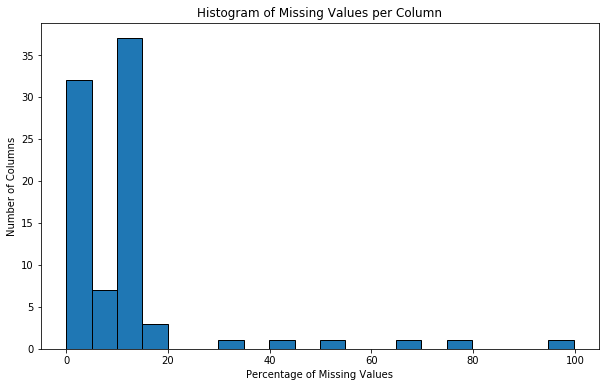

In [13]:
plt.figure(figsize=(10, 6))
plt.hist(null_col_before, bins=20, edgecolor='black')
plt.xlabel('Percentage of Missing Values')
plt.ylabel('Number of Columns')
plt.title('Histogram of Missing Values per Column')
plt.show()

In [14]:
# Columns that have greater than 20 percent of values being null
outliers = null_col_before[null_col_before > 20]
outlier_columns = outliers.index.tolist()
print("Columns with greater than 20 percent of values being null are:", outlier_columns)


Columns with greater than 20 percent of values being null are: ['TITEL_KZ', 'AGER_TYP', 'KK_KUNDENTYP', 'KBA05_BAUMAX', 'GEBURTSJAHR', 'ALTER_HH']


In [15]:
azdias = azdias.drop(outlier_columns, axis=1)

In [16]:
# check to make sure the 6 columns were dropped, should be 79 now instead of 85.
azdias.shape

(891221, 79)

#### Discussion 1.1.2: Assess Missing Data in Each Column

There were 61 columns that had NaN values.  Upon assessing these columns using a histogram it was seen that any columns with over 20% of their data being NaN appeared to be outliers. The outlier columns were: 'TITEL_KZ', 'AGER_TYP', 'KK_KUNDENTYP', 'KBA05_BAUMAX', 'GEBURTSJAHR', 'ALTER_HH'. These columns were deleted to not cause instability in the data. 


#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [17]:
def find_null_row(dataset):
    pd.set_option('display.max_rows', None)  # Display all rows
    pd.set_option('display.max_columns', None)  # Display all columns
    perc_null_row = dataset.isnull().sum().sort_values(ascending=False) / dataset.shape[1] * 100
    print("Number with Null: {}".format(sum(perc_null_row > 0)))
    return perc_null_row

In [18]:
null_row_before = find_null_row(azdias)
print(null_row_before)

Number with Null: 55
KKK                      200081.012658
REGIOTYP                 200081.012658
W_KEIT_KIND_HH           187326.582278
MOBI_REGIO               168764.556962
KBA05_ANTG4              168764.556962
KBA05_ANTG3              168764.556962
KBA05_ANTG2              168764.556962
KBA05_ANTG1              168764.556962
KBA05_GBZ                168764.556962
PLZ8_ANTG2               147487.341772
PLZ8_ANTG1               147487.341772
PLZ8_ANTG3               147487.341772
PLZ8_ANTG4               147487.341772
PLZ8_BAUMAX              147487.341772
PLZ8_HHZ                 147487.341772
PLZ8_GBZ                 147487.341772
HEALTH_TYP               140754.430380
SHOPPER_TYP              140754.430380
VERS_TYP                 140754.430380
NATIONALITAET_KZ         137107.594937
PRAEGENDE_JUGENDJAHRE    136916.455696
KBA13_ANZAHL_PKW         133924.050633
ANZ_HAUSHALTE_AKTIV      126089.873418
CAMEO_INTL_2015          125762.025316
CAMEO_DEU_2015           125762.025316
CAME

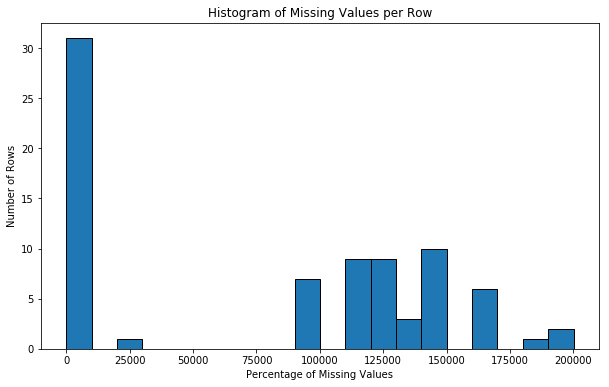

In [19]:
plt.figure(figsize=(10, 6))
plt.hist(null_row_before, bins=20, edgecolor='black')
plt.xlabel('Percentage of Missing Values')
plt.ylabel('Number of Rows')
plt.title('Histogram of Missing Values per Row')
plt.show()

In [20]:
# Divide the data into 2 subsets: one for points above some threshold for missing values, 
# second subset for points below that threshold.

more_than_10 = azdias[azdias.isnull().sum(axis = 1)>10]
less_than_eq_10 = azdias[azdias.isnull().sum(axis = 1)<=10]

zero_null_row = null_row_before[null_row_before == 0].index.tolist()


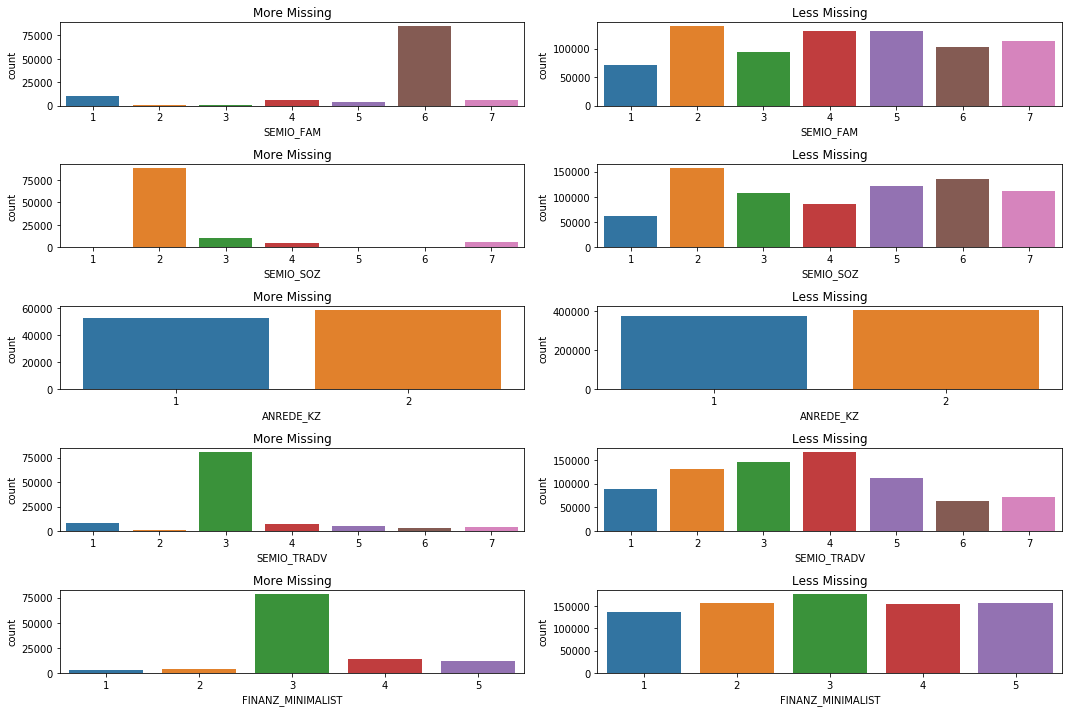

In [21]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

fig, ax = plt.subplots(figsize= (15,10),nrows = 5,ncols = 2)

for i in range(5):
    sns.countplot(more_than_10[zero_null_row[i]], ax = ax[i][0])
    sns.countplot(less_than_eq_10[zero_null_row[i]], ax = ax[i][1])
    ax[i][0].set_title("More Missing")
    ax[i][1].set_title("Less Missing")
    

plt.tight_layout()
plt.show()

#### Discussion 1.1.3: Assess Missing Data in Each Row

The range that stands out in the missing values per row histogram is around 10-32. I chose two subsets with ten or less missing values and above ten missing values. In the comparison between More missing and Less missing diagrams, in the GREEN_AVANTGARDE column there was very little difference. However the final four columns had significant differences. 

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [22]:
# How many features are there of each data type?

columns = list(less_than_eq_10.columns)

features = feat_info[feat_info['attribute'].isin(columns)]
counts = features['type'].value_counts()

counts

ordinal        49
categorical    18
numeric         6
mixed           6
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [23]:
# Assess categorical variables: which multi = []
# which one needs to be re-encoded?

categorical = features[features['type'] == 'categorical']['attribute']

multi_level = []
binary = []

for i in categorical:
    multi_level.append(i) if (len(less_than_eq_10[i].unique()) > 4) else binary.append(i)

print("Multi Level Categorical Features: {}".format(multi_level))
print()
print("Binary Categorical Features: {}".format(binary))

for attribute in binary:
    print(attribute, less_than_eq_10[attribute].unique())





Multi Level Categorical Features: ['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']

Binary Categorical Features: ['ANREDE_KZ', 'GREEN_AVANTGARDE', 'NATIONALITAET_KZ', 'SOHO_KZ', 'VERS_TYP', 'OST_WEST_KZ']
ANREDE_KZ [2 1]
GREEN_AVANTGARDE [0 1]
NATIONALITAET_KZ [  1.   3.   2.  nan]
SOHO_KZ [ 1.  0.]
VERS_TYP [  2.   1.  nan]
OST_WEST_KZ ['W' 'O']


In [24]:
less_than_eq_10.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,VERS_TYP,ZABEOTYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
1,1.0,2,5.0,1,5,2,5,4,5,1,10.0,0,3.0,21.0,6.0,5.0,3.0,2.0,1.0,1.0,14.0,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,3.0,1.0,2.0,5,2.0,0.0,6.0,3.0,9.0,11.0,0.0,8.0,1.0,1992.0,W,4.0,8,8A,51,0.0,0.0,0.0,2.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2,3.0,1,4,1,2,3,5,1,10.0,1,3.0,3.0,1.0,1.0,1.0,3.0,2.0,1.0,15.0,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,2.0,0.0,1.0,5,1.0,0.0,4.0,3.0,9.0,10.0,0.0,1.0,5.0,1992.0,W,2.0,4,4C,24,1.0,3.0,1.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2,2.0,4,2,5,2,1,2,6,1.0,0,2.0,NaN,NaN,NaN,NaN,9.0,4.0,1.0,8.0,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,1.0,0.0,1.0,3,0.0,0.0,1.0,NaN,9.0,1.0,0.0,1.0,4.0,1997.0,W,7.0,2,2A,12,4.0,1.0,0.0,0.0,4.0,4.0,2.0,6.0,4.0,NaN,4.0,1.0,NaN,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1,5.0,4,3,4,1,3,2,5,5.0,0,3.0,32.0,10.0,10.0,5.0,3.0,2.0,1.0,8.0,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,2.0,0.0,2.0,4,4.0,0.0,5.0,2.0,9.0,3.0,0.0,1.0,4.0,1992.0,W,3.0,6,6B,43,1.0,4.0,1.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,1.0,2,2.0,3,1,5,2,2,5,2,1.0,0,3.0,8.0,2.0,1.0,1.0,4.0,2.0,1.0,3.0,3.0,2,4,7,4,2,2,2,5,7,4,4,4,7,6,0.0,0.0,2.0,4,1.0,0.0,5.0,6.0,9.0,5.0,0.0,1.0,5.0,1992.0,W,7.0,8,8C,54,2.0,2.0,0.0,0.0,4.0,6.0,2.0,7.0,4.0,4.0,4.0,1.0,5.0,1300.0,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0


In [25]:
# Re-encode categorical variable(s) to be kept in the analysis.

less_than_eq_10 = less_than_eq_10.replace({'OST_WEST_KZ':{'W':0,'O':1}})


In [26]:
# Drop multi-level categorical features 
for column in multi_level:
    less_than_eq_10.drop(column,axis = 1,inplace=True)

#### Discussion 1.2.1: Re-Encode Categorical Features

The binary categorical features were kept with one being converted from letters to integers (OST_WEST_KZ). The columns with multi_level categorical features were dropped. 

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

1.18. PRAEGENDE_JUGENDJAHRE
Dominating movement of person's youth (avantgarde vs. mainstream; east vs. west)

-1: unknown
0: unknown
1: 40s - war years (Mainstream, E+W)
2: 40s - reconstruction years (Avantgarde, E+W)
3: 50s - economic miracle (Mainstream, E+W)
4: 50s - milk bar / Individualisation (Avantgarde, E+W)
5: 60s - economic miracle (Mainstream, E+W)
6: 60s - generation 68 / student protestors (Avantgarde, W)
7: 60s - opponents to the building of the Wall (Avantgarde, E)
8: 70s - family orientation (Mainstream, E+W)
9: 70s - peace movement (Avantgarde, E+W)
10: 80s - Generation Golf (Mainstream, W)
11: 80s - ecological awareness (Avantgarde, W)
12: 80s - FDJ / communist party youth organisation (Mainstream, E)
13: 80s - Swords into ploughshares (Avantgarde, E)
14: 90s - digital media kids (Mainstream, E+W)
15: 90s - ecological awareness (Avantgarde, E+W)

In [27]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

# Mapping for decade values
""" 40s = 1 for values 1, 2 in dictionary
    50s = 3 for values 3, 4  
    60s = 5 for values 5, 6, 7
    70s = 8 for values 8, 9 
    80s = 10 for values 10, 11, 12, 13
    90s = 14 for values 14, 15 """
    
decade_mapping = {1:1, 2:1, 3:3, 4:3, 5:5, 6:5, 7:5, 8:8, 9:8, 10:10, 11:10, 12:10, 13:10, 14:14, 15:14}

# Mapping for movement values
    # 1: Mainstream
   # 2: Avantgarde

movement_mapping = {1:1, 2:2, 3:1, 4:2, 5:1, 6:2, 7:2, 8:1, 9:2, 10:1, 11:2, 12:1, 13:2, 14:1, 15:2}
   

# Create new variables
less_than_eq_10['DECADE'] = less_than_eq_10['PRAEGENDE_JUGENDJAHRE'].replace(decade_mapping)
less_than_eq_10['MOVEMENT'] = less_than_eq_10['PRAEGENDE_JUGENDJAHRE'].replace(movement_mapping)


In [28]:
less_than_eq_10[['PRAEGENDE_JUGENDJAHRE','DECADE','MOVEMENT']].head()

,PRAEGENDE_JUGENDJAHRE,DECADE,MOVEMENT
1,14.0,14.0,1.0
2,15.0,14.0,2.0
3,8.0,8.0,1.0
4,8.0,8.0,1.0
5,3.0,3.0,1.0


### 4.3. CAMEO_INTL_2015
German CAMEO: Wealth / Life Stage Typology, mapped to international code
- -1: unknown
- 11: Wealthy Households - Pre-Family Couples & Singles
- 12: Wealthy Households - Young Couples With Children
- 13: Wealthy Households - Families With School Age Children
- 14: Wealthy Households - Older Families &  Mature Couples
- 15: Wealthy Households - Elders In Retirement
- 21: Prosperous Households - Pre-Family Couples & Singles
- 22: Prosperous Households - Young Couples With Children
- 23: Prosperous Households - Families With School Age Children
- 24: Prosperous Households - Older Families & Mature Couples
- 25: Prosperous Households - Elders In Retirement
- 31: Comfortable Households - Pre-Family Couples & Singles
- 32: Comfortable Households - Young Couples With Children
- 33: Comfortable Households - Families With School Age Children
- 34: Comfortable Households - Older Families & Mature Couples
- 35: Comfortable Households - Elders In Retirement
- 41: Less Affluent Households - Pre-Family Couples & Singles
- 42: Less Affluent Households - Young Couples With Children
- 43: Less Affluent Households - Families With School Age Children
- 44: Less Affluent Households - Older Families & Mature Couples
- 45: Less Affluent Households - Elders In Retirement
- 51: Poorer Households - Pre-Family Couples & Singles
- 52: Poorer Households - Young Couples With Children
- 53: Poorer Households - Families With School Age Children
- 54: Poorer Households - Older Families & Mature Couples
- 55: Poorer Households - Elders In Retirement
- XX: unknown

In [29]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables, wealth and life_stage

# wealth column
""" 1= Wealthy Households
    2= Prosperous Households
    3= Comfortable Households 
    4= Less Affluent Households 
    5= Poorer Households"""

wealth = {'11':1,'12':1,'13':1,'14':1,'15':1,
          '21':2,'22':2,'23':2,'24':2,'25':2,
          '31':3,'32':3,'33':3,'34':3,'35':3,
          '41':4,'42':4,'43':4,'44':4,'45':4,
          '51':5,'52':5,'53':5,'54':5,'55':5
         }

# life_stage column. 
""" 1= Pre-Family Couples & Singles
    2= Young Couples With Children
    3= Families With School Age Children
    4= Older Families & Mature Couples
    5= Elders In Retirement"""

life_stage = {'11':1, '12':2, '13':3, '14':4, '15':5,
              '21':1, '22':2, '23':3, '24':4, '25':5,
              '31':1, '32':2, '33':3, '34':4, '35':5,
              '41':1, '42':2, '43':3, '44':4, '45':5, 
              '51':1, '52':2, '53':3, '54':4, '55':5
             }

less_than_eq_10['WEALTH'] = less_than_eq_10['CAMEO_INTL_2015'].replace(wealth)
less_than_eq_10['LIFE_STAGE'] = less_than_eq_10['CAMEO_INTL_2015'].replace(life_stage)

In [30]:
less_than_eq_10[['CAMEO_INTL_2015', 'WEALTH', 'LIFE_STAGE']].head()

,CAMEO_INTL_2015,WEALTH,LIFE_STAGE
1,51,5.0,1.0
2,24,2.0,4.0
3,12,1.0,2.0
4,43,4.0,3.0
5,54,5.0,4.0


In [31]:
less_than_eq_10.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,VERS_TYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,DECADE,MOVEMENT,WEALTH,LIFE_STAGE
1,1.0,2,1,5,2,5,4,5,0,3.0,21.0,6.0,1.0,14.0,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,1.0,2.0,2.0,0.0,6.0,3.0,9.0,11.0,0.0,1.0,1992.0,0,4.0,51,0.0,0.0,0.0,2.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0,14.0,1.0,5.0,1.0
2,3.0,2,1,4,1,2,3,5,1,3.0,3.0,1.0,1.0,15.0,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,0.0,1.0,1.0,0.0,4.0,3.0,9.0,10.0,0.0,5.0,1992.0,0,2.0,24,1.0,3.0,1.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0,14.0,2.0,2.0,4.0
3,4.0,2,4,2,5,2,1,2,0,2.0,NaN,NaN,1.0,8.0,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,0.0,1.0,0.0,0.0,1.0,NaN,9.0,1.0,0.0,4.0,1997.0,0,7.0,12,4.0,1.0,0.0,0.0,4.0,4.0,2.0,6.0,4.0,NaN,4.0,1.0,NaN,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0,8.0,1.0,1.0,2.0
4,3.0,1,4,3,4,1,3,2,0,3.0,32.0,10.0,1.0,8.0,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,0.0,2.0,4.0,0.0,5.0,2.0,9.0,3.0,0.0,4.0,1992.0,0,3.0,43,1.0,4.0,1.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0,8.0,1.0,4.0,3.0
5,1.0,2,3,1,5,2,2,5,0,3.0,8.0,2.0,1.0,3.0,3.0,2,4,7,4,2,2,2,5,7,4,4,4,7,6,0.0,2.0,1.0,0.0,5.0,6.0,9.0,5.0,0.0,5.0,1992.0,0,7.0,54,2.0,2.0,0.0,0.0,4.0,6.0,2.0,7.0,4.0,4.0,4.0,1.0,5.0,1300.0,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0,3.0,1.0,5.0,4.0


#### Discussion 1.2.2: Engineer Mixed-Type Features

For the PRAEGENDE_JUGENDJAHRE column I created two new columns with decade information and movement information. The decade information decribes the generation of the individual by decade and the movement describes main movement of the decade whether it was mainstream or avantgarde. 
For the CAMEO_INTL_2015 column the information was subdivided into two new columns called wealth and life_stage.  The wealth column is the first digit(tens place) of the variable in the original Cameo column while the life_stage is the second digit (ones place). 

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [32]:
# drop mixed values
mixed = list(features[features['type'] == 'mixed']['attribute'])

for attr in mixed:
    less_than_eq_10.drop(attr,axis = 1,inplace=True)
    

In [33]:
less_than_eq_10.shape

(780153, 65)

In [34]:
# double check for rows that have more than a third of their columns with null values ()
nan_counts = less_than_eq_10.isnull().sum(axis=1)
rows_more_than_30perc_null = less_than_eq_10[nan_counts > 22]

print("Number of rows with more than 22 (~30%) NaN values:", len(rows_more_than_30perc_null))

Number of rows with more than 22 (~30%) NaN values: 0


In [35]:
less_than_eq_10.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,NATIONALITAET_KZ,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,VERS_TYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,DECADE,MOVEMENT,WEALTH,LIFE_STAGE
1,1.0,2,1,5,2,5,4,5,0,3.0,1.0,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,1.0,2.0,2.0,0.0,6.0,3.0,9.0,11.0,0.0,1.0,1992.0,0,0.0,0.0,0.0,2.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,5.0,4.0,3.0,5.0,4.0,14.0,1.0,5.0,1.0
2,3.0,2,1,4,1,2,3,5,1,3.0,1.0,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,0.0,1.0,1.0,0.0,4.0,3.0,9.0,10.0,0.0,5.0,1992.0,0,1.0,3.0,1.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,4.0,4.0,3.0,5.0,2.0,14.0,2.0,2.0,4.0
3,4.0,2,4,2,5,2,1,2,0,2.0,1.0,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,0.0,1.0,0.0,0.0,1.0,NaN,9.0,1.0,0.0,4.0,1997.0,0,4.0,1.0,0.0,0.0,4.0,4.0,2.0,6.0,4.0,NaN,4.0,1.0,NaN,596.0,2.0,2.0,2.0,0.0,3.0,4.0,2.0,3.0,3.0,8.0,1.0,1.0,2.0
4,3.0,1,4,3,4,1,3,2,0,3.0,1.0,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,0.0,2.0,4.0,0.0,5.0,2.0,9.0,3.0,0.0,4.0,1992.0,0,1.0,4.0,1.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,3.0,3.0,4.0,6.0,5.0,8.0,1.0,4.0,3.0
5,1.0,2,3,1,5,2,2,5,0,3.0,1.0,3.0,2,4,7,4,2,2,2,5,7,4,4,4,7,6,0.0,2.0,1.0,0.0,5.0,6.0,9.0,5.0,0.0,5.0,1992.0,0,2.0,2.0,0.0,0.0,4.0,6.0,2.0,7.0,4.0,4.0,4.0,1.0,5.0,1300.0,2.0,3.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0,3.0,1.0,5.0,4.0


In [36]:
# rename chosen dataset to more user friendly name
cleaned_df = less_than_eq_10

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [37]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    print("Null values before conversion: {}".format(df.isnull().sum().sum()))
    
    # convert missing value codes into NaNs, ...
    for i in range(len(feat_info)):
        row = feat_info.iloc[i]
        missing_data = row['missing_or_unknown'][1:-1].split(',')
        missing_data = [int(x) if (x != 'X') and (x != 'XX') and (x!='') else x for x in missing_data]
        if(missing_data != ''):
            df = df.replace({row['attribute']:missing_data},np.nan)
            
    print("Conversion complete")      
            
    null_col_before = find_null(df)  #call to find_null function
        
             
      
    # remove outliers from dataset
    outliers = ['TITEL_KZ', 'AGER_TYP', 'KK_KUNDENTYP', 'KBA05_BAUMAX', 'GEBURTSJAHR', 'ALTER_HH']  
    df = df.drop(outliers, axis=1)
    print("Outlier columns dropped")
    
    df = df[df.isnull().sum(axis = 1)<=10]


  
    categorical = features[features['type'] == 'categorical']['attribute']

    multi_level = []
    binary = []

    for i in categorical:
        multi_level.append(i) if (len(df[i].unique()) > 4) else binary.append(i)
        
    df = df.replace({'OST_WEST_KZ':{'W':0,'O':1}})
        

    
    
    for column in multi_level:
        #if column in df.columns:  # Check if the column exists in the DataFrame
        df.drop(column, axis=1, inplace=True)
       # else:
           # print(f"Column '{column}' does not exist in the DataFrame.")
        
    decade_mapping = {1:1, 2:1, 3:3, 4:3, 5:5, 6:5, 7:5, 8:8, 9:8, 10:10, 11:10, 12:10, 13:10, 14:14, 15:14}
    movement_mapping = {1:1, 2:2, 3:1, 4:2, 5:1, 6:2, 7:2, 8:1, 9:2, 10:1, 11:2, 12:1, 13:2, 14:1, 15:2}
    
    
    # Create new variables
    #if 'PRAEGENDE_JUGENDJAHRE' in df.columns:
    df['DECADE'] = df['PRAEGENDE_JUGENDJAHRE'].replace(decade_mapping)
    df['MOVEMENT'] = df['PRAEGENDE_JUGENDJAHRE'].replace(movement_mapping)
       #df.drop('PRAEGENDE_JUGENDJAHRE', axis=1, inplace=True)
    #else:
        #print("Column 'PRAEGENDE_JUGENDJAHRE' does not exist in the DataFrame.")
        
 

    # Investigate "CAMEO_INTL_2015" and engineer two new variables, wealth and life_stage

    # wealth column
    """ 1= Wealthy Households
        2= Prosperous Households
        3= Comfortable Households 
        4= Less Affluent Households 
        5= Poorer Households"""

    wealth = {'11':1,'12':1,'13':1,'14':1,'15':1,
              '21':2,'22':2,'23':2,'24':2,'25':2,
              '31':3,'32':3,'33':3,'34':3,'35':3,
              '41':4,'42':4,'43':4,'44':4,'45':4,
              '51':5,'52':5,'53':5,'54':5,'55':5
             }

    # life_stage column. 
    """ 1= Pre-Family Couples & Singles
        2= Young Couples With Children
        3= Families With School Age Children
        4= Older Families & Mature Couples
        5= Elders In Retirement"""

    life_stage = {'11':1, '12':2, '13':3, '14':4, '15':5,
                  '21':1, '22':2, '23':3, '24':4, '25':5,
                  '31':1, '32':2, '33':3, '34':4, '35':5,
                  '41':1, '42':2, '43':3, '44':4, '45':5, 
                  '51':1, '52':2, '53':3, '54':4, '55':5
                 }

    #if 'CAMEO_INTL_2015' in df.columns:
    df['WEALTH'] = df['CAMEO_INTL_2015'].replace(wealth)
    df['LIFE_STAGE'] = df['CAMEO_INTL_2015'].replace(life_stage)
            
        
    #drop mixed value
    mixed = list(features[features['type'] == 'mixed']['attribute'])
    
    for attr in mixed:
        df.drop(attr,axis = 1,inplace=True)
        
    print("Dataframe has been cleaned")
     
    # Return the cleaned dataframe.
    return df
    
    

In [38]:
azdias_test = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep = ';')
assert_test_df = clean_data(azdias_test)

Null values before conversion: 4896838
Conversion complete
Number with Null: 61
Outlier columns dropped
Dataframe has been cleaned


In [39]:
assert assert_test_df.shape[0] == cleaned_df.shape[0], "clean_data function is not working properly, rows mismatch"
assert assert_test_df.shape[1] == cleaned_df.shape[1], "clean_data function is not working properly, columns mismatch"
print("If this is all you see, you passed the tests")

If this is all you see, you passed the tests


## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](https://scikit-learn.org/0.16/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [40]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.

# Columns with NaN values
nan_columns = cleaned_df.columns[cleaned_df.isna().any()].tolist()
print(nan_columns)


['ALTERSKATEGORIE_GROB', 'HEALTH_TYP', 'NATIONALITAET_KZ', 'RETOURTYP_BK_S', 'VERS_TYP', 'W_KEIT_KIND_HH', 'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'KONSUMNAEHE', 'KBA05_ANTG1', 'KBA05_ANTG2', 'KBA05_ANTG3', 'KBA05_ANTG4', 'KBA05_GBZ', 'BALLRAUM', 'EWDICHTE', 'INNENSTADT', 'GEBAEUDETYP_RASTER', 'KKK', 'MOBI_REGIO', 'ONLINE_AFFINITAET', 'REGIOTYP', 'KBA13_ANZAHL_PKW', 'PLZ8_ANTG1', 'PLZ8_ANTG2', 'PLZ8_ANTG3', 'PLZ8_ANTG4', 'PLZ8_HHZ', 'PLZ8_GBZ', 'ARBEIT', 'ORTSGR_KLS9', 'RELAT_AB', 'DECADE', 'MOVEMENT', 'WEALTH', 'LIFE_STAGE']


In [41]:
# Total number of NaN values in dataset
nan_counts = cleaned_df.isna().sum()
print(nan_counts)

ALTERSKATEGORIE_GROB      2625
ANREDE_KZ                    0
FINANZ_MINIMALIST            0
FINANZ_SPARER                0
FINANZ_VORSORGER             0
FINANZ_ANLEGER               0
FINANZ_UNAUFFAELLIGER        0
FINANZ_HAUSBAUER             0
GREEN_AVANTGARDE             0
HEALTH_TYP               34524
NATIONALITAET_KZ         31899
RETOURTYP_BK_S            3834
SEMIO_SOZ                    0
SEMIO_FAM                    0
SEMIO_REL                    0
SEMIO_MAT                    0
SEMIO_VERT                   0
SEMIO_LUST                   0
SEMIO_ERL                    0
SEMIO_KULT                   0
SEMIO_RAT                    0
SEMIO_KRIT                   0
SEMIO_DOM                    0
SEMIO_KAEM                   0
SEMIO_PFLICHT                0
SEMIO_TRADV                  0
SOHO_KZ                      0
VERS_TYP                 34524
ANZ_PERSONEN                 0
ANZ_TITEL                    0
HH_EINKOMMEN_SCORE           0
W_KEIT_KIND_HH           56282
WOHNDAUE

In [42]:
# Apply imputer to dataset to clean NaN values
numerical_columns = cleaned_df.select_dtypes(include='number')

imputer = Imputer(strategy='mean')
imputer.fit(cleaned_df)
cleaned_df_imputed = imputer.transform(cleaned_df)

# test that null values deleted
cleaned_df_imputed = pd.DataFrame(cleaned_df_imputed, columns=cleaned_df.columns)

null_counts = cleaned_df_imputed.isnull().sum()
print(null_counts)

ALTERSKATEGORIE_GROB     0
ANREDE_KZ                0
FINANZ_MINIMALIST        0
FINANZ_SPARER            0
FINANZ_VORSORGER         0
FINANZ_ANLEGER           0
FINANZ_UNAUFFAELLIGER    0
FINANZ_HAUSBAUER         0
GREEN_AVANTGARDE         0
HEALTH_TYP               0
NATIONALITAET_KZ         0
RETOURTYP_BK_S           0
SEMIO_SOZ                0
SEMIO_FAM                0
SEMIO_REL                0
SEMIO_MAT                0
SEMIO_VERT               0
SEMIO_LUST               0
SEMIO_ERL                0
SEMIO_KULT               0
SEMIO_RAT                0
SEMIO_KRIT               0
SEMIO_DOM                0
SEMIO_KAEM               0
SEMIO_PFLICHT            0
SEMIO_TRADV              0
SOHO_KZ                  0
VERS_TYP                 0
ANZ_PERSONEN             0
ANZ_TITEL                0
HH_EINKOMMEN_SCORE       0
W_KEIT_KIND_HH           0
WOHNDAUER_2008           0
ANZ_HAUSHALTE_AKTIV      0
ANZ_HH_TITEL             0
KONSUMNAEHE              0
MIN_GEBAEUDEJAHR         0
O

In [43]:
# Apply feature scaling to the general population demographics data.

scaler = StandardScaler()
cleaned_df_fit = scaler.fit_transform(cleaned_df_imputed)

# Convert the scaled array back to a DataFrame
cleaned_df_scaled = pd.DataFrame(cleaned_df_fit, columns=cleaned_df_imputed.columns)

# Check the scaled DataFrame
print(cleaned_df_scaled.head())

   ALTERSKATEGORIE_GROB  ANREDE_KZ  FINANZ_MINIMALIST  FINANZ_SPARER  \
0             -1.767099   0.958395          -1.488140       1.539080   
1              0.198771   0.958395          -1.488140       0.866538   
2              1.181706   0.958395           0.688928      -0.478545   
3              0.198771  -1.043411           0.688928       0.193996   
4             -1.767099   0.958395          -0.036761      -1.151087   

   FINANZ_VORSORGER  FINANZ_ANLEGER  FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER  \
0         -1.045251        1.467273               0.980071          1.326876   
1         -1.771610       -0.569041               0.262544          1.326876   
2          1.133828       -0.569041              -1.172510         -0.817895   
3          0.407468       -1.247812               0.262544         -0.817895   
4          1.133828       -0.569041              -0.454983          1.326876   

   GREEN_AVANTGARDE  HEALTH_TYP  NATIONALITAET_KZ  RETOURTYP_BK_S  SEMIO_SOZ  \
0     

### Discussion 2.1: Apply Feature Scaling

I applied imputer using mean as it uses every value in dataset thereby making a good representation of the data and since we cleaned our data of outliers it would be the better choice.  I used StandarScaler so as to normalize features and bring them to a similar scale. 

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [44]:
# Apply PCA to the data.

pca= PCA()
pca.fit(cleaned_df_scaled)


PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

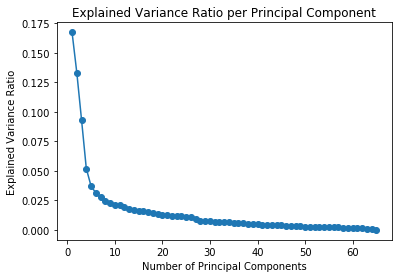

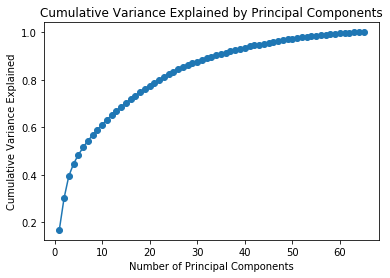

In [45]:
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

# Plotting the explained variance ratio
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio per Principal Component')
plt.show()

# Plotting the cumulative variance explained
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Variance Explained')
plt.title('Cumulative Variance Explained by Principal Components')
plt.show()

In [46]:
# Re-apply PCA to the data while selecting for number of components to retain.

pca_redo = PCA(n_components=20)
pca_20 = pca_redo.fit_transform(cleaned_df_scaled)

In [47]:
cleaned_df_scaled.shape

(780153, 65)

### Discussion 2.2: Perform Dimensionality Reduction

I chose 20 components as this was the area in the plot visual above where the variance ratio started leveling off and is at around .8.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [48]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

def mapping_pca(pca, component):
    df = pd.DataFrame(pca.components_, columns=list(cleaned_df.columns))
    w = df.iloc[component]
    return w.sort_values(ascending= False)

mapping_pca(pca_redo,0)



PLZ8_ANTG3               0.224339
PLZ8_ANTG4               0.217596
WEALTH                   0.205723
HH_EINKOMMEN_SCORE       0.203077
ORTSGR_KLS9              0.195264
EWDICHTE                 0.193512
FINANZ_HAUSBAUER         0.160973
PLZ8_ANTG2               0.152662
KBA05_ANTG4              0.151393
FINANZ_SPARER            0.148609
ARBEIT                   0.142139
ANZ_HAUSHALTE_AKTIV      0.134366
KBA05_ANTG3              0.134235
RELAT_AB                 0.134016
SEMIO_PFLICHT            0.117083
SEMIO_REL                0.114439
DECADE                   0.107176
SEMIO_RAT                0.096328
SEMIO_TRADV              0.090746
SEMIO_MAT                0.080143
SEMIO_FAM                0.079009
FINANZ_UNAUFFAELLIGER    0.077160
SEMIO_KULT               0.073900
REGIOTYP                 0.072471
FINANZ_ANLEGER           0.071402
NATIONALITAET_KZ         0.065262
OST_WEST_KZ              0.053076
KKK                      0.043891
SEMIO_SOZ                0.042928
PLZ8_HHZ      

In [49]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

mapping_pca(pca_redo,1)


ALTERSKATEGORIE_GROB     0.257599
FINANZ_VORSORGER         0.230137
SEMIO_ERL                0.227619
SEMIO_LUST               0.181016
RETOURTYP_BK_S           0.163991
W_KEIT_KIND_HH           0.118868
FINANZ_HAUSBAUER         0.117152
SEMIO_KRIT               0.114738
SEMIO_KAEM               0.110636
PLZ8_ANTG3               0.096779
EWDICHTE                 0.094451
ORTSGR_KLS9              0.093104
PLZ8_ANTG4               0.092476
ANREDE_KZ                0.087755
WEALTH                   0.076933
KBA05_ANTG4              0.071133
ARBEIT                   0.069114
SEMIO_DOM                0.068351
PLZ8_ANTG2               0.066626
RELAT_AB                 0.066482
FINANZ_MINIMALIST        0.064233
ANZ_HAUSHALTE_AKTIV      0.064224
WOHNDAUER_2008           0.058269
HH_EINKOMMEN_SCORE       0.057100
KBA05_ANTG3              0.045030
VERS_TYP                 0.032813
ANZ_HH_TITEL             0.031339
OST_WEST_KZ              0.026391
REGIOTYP                 0.022942
PLZ8_HHZ      

In [50]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

mapping_pca(pca_redo,2)

SEMIO_VERT               0.346539
SEMIO_SOZ                0.264281
SEMIO_FAM                0.251871
SEMIO_KULT               0.236263
FINANZ_MINIMALIST        0.154961
RETOURTYP_BK_S           0.107555
FINANZ_VORSORGER         0.097927
W_KEIT_KIND_HH           0.089361
ALTERSKATEGORIE_GROB     0.076276
SEMIO_REL                0.072647
SEMIO_LUST               0.062348
SEMIO_MAT                0.056695
GREEN_AVANTGARDE         0.048060
ORTSGR_KLS9              0.047106
EWDICHTE                 0.046542
MOVEMENT                 0.046183
PLZ8_ANTG4               0.046084
PLZ8_ANTG3               0.045697
ARBEIT                   0.034766
WOHNDAUER_2008           0.032080
RELAT_AB                 0.031708
PLZ8_ANTG2               0.030492
WEALTH                   0.027456
KBA05_ANTG4              0.027309
ANZ_HAUSHALTE_AKTIV      0.025438
OST_WEST_KZ              0.015188
VERS_TYP                 0.014482
ANZ_HH_TITEL             0.013212
ANZ_TITEL                0.009748
KBA05_ANTG3   

## Discussion 2.3: Interpret Principal Components

Detailed investigation of the first few principal components generated. 

###  First component:
##### Items with strong positive correlation
PLZ8_ANTG3 (# of 6-10 family homes in region)  0.224339    
PLZ8_ANTG4 (# of 10+ family homes in region)   0.217596       
WEALTH  (wealth status)                        0.205723     

#### Items with strong negative correlation:
PLZ8_ANTG1 (# of 1-2 family homes in region)   -0.223977   
MOBI_REGIO (movement patterns)                 -0.239897

Most significant type of factors for component one are related to home number status of region, wealth/finance and movement patterns of individuals.

### Second component:
#### Items with strong positive corrlation:
ALTERSKATEGORIE_GROB (age range based on name)    0.257599   
FINANZ_VORSORGER (financial level type)           0.230137     
SEMIO_ERL  (event oriented personality type)      0.227619     

#### Items with strong negative correlation:
DECADE   (Decade of greatest significance)        -0.250956     
SEMIO_REL (religion type)                         -0.251910    

Most significant type of factors for component two are related to age, personality type, financial status, religion and decade of most significance. These items are in a wider range than component one in how they are inter-related.

### Third component:
#### Items with strong positive corrlation:
SEMIO_VERT (level of dreamful personality type)    0.346539  
SEMIO_SOZ (social personality type)                0.264280   
SEMIO_FAM  (family minded personality type)        0.251871 

#### Items with strong negative correlation:
SEMIO_KAEM (combative attitude personality type)   -0.337793    
ANREDE_KZ (gender)                                 -0.369571

Most significant type of factors for component three are related to personaltiy and gender.



## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [51]:
# run k-means clustering on a number of cluster counts and compute the average within-cluster distances.

def kmeans_predict(dataset, cluster_count):
    
    score = []
    models = []
    for num in cluster_count:
        model = KMeans(num)
        fitted = model.fit(dataset)
        models.append(fitted)
        score.append(np.abs(fitted.score(dataset)))
    
    return models, score


cluster_num = range(1, 30)

model_list,score_list = kmeans_predict(pca_20, cluster_num)



Index of scores which is not decreasing: [13, 15]


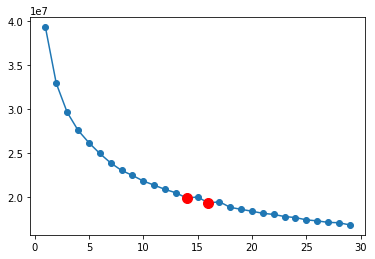

In [52]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.

# output the indices where the scores are not decreasing.
diff_in_score = []
for i in range(len(score_list)):
    if (i != max(range(len(score_list)))) and ((score_list[i+1] - score_list[i] )>0): 
        diff_in_score.append(i)
print("Index of scores which is not decreasing: {}".format(diff_in_score))

plt.plot(cluster_num,score_list,marker = 'o')
for i in diff_in_score:
    _ = plt.plot(list(cluster_num)[i],score_list[i],color = 'r',marker = 'o',markersize = 10)


In [53]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

next_model_list, next_score_list = kmeans_predict(pca_20,[10])

# azdias_predict will contain the cluster predictions
azdias_predict = next_model_list[0].predict(pca_20)

### Discussion 3.1: Apply Clustering to General Population

I decided on 10 clusters as this is where from looking at the visualization I can start to see an elbow and the line seems to lose some continuity. 

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [54]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep = ';')


In [55]:
customers.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2,4,1,5.0,5,1,5,1,2,2,2,0,4.0,1,1,20.0,5.0,2.0,2.0,10.0,5.0,1,4,5.0,6,5,2,6,6,7,3,4,1,3,1,1,2,1,3,0.0,0.0,1,3,10.0,2.0,0.0,1.0,NaN,6.0,9.0,1.0,0.0,1.0,5.0,1992.0,W,7.0,1,1A,13,2.0,2.0,0.0,0.0,0.0,4.0,3.0,2.0,4.0,4.0,1.0,4.0,3.0,1.0,1201.0,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0
1,-1,4,1,NaN,5,1,5,1,3,2,2,0,NaN,0,1,NaN,NaN,NaN,NaN,NaN,NaN,1,0,NaN,3,6,2,6,7,5,3,4,1,3,3,2,4,1,3,0.0,0.0,1,3,11.0,3.0,0.0,NaN,NaN,0.0,9.0,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1,4,2,2.0,5,1,5,1,4,4,2,0,3.0,1,2,13.0,3.0,1.0,1.0,10.0,5.0,1,4,5.0,2,2,1,3,3,7,7,1,2,7,5,6,4,1,1,0.0,0.0,2,3,6.0,1.0,0.0,1.0,NaN,6.0,9.0,1.0,0.0,8.0,1.0,1992.0,W,2.0,5,5D,34,2.0,2.0,0.0,0.0,0.0,3.0,7.0,4.0,1.0,3.0,3.0,3.0,1.0,7.0,433.0,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0
3,1,4,1,2.0,5,1,5,2,1,2,6,0,10.0,0,2,0.0,0.0,0.0,0.0,9.0,4.0,1,1,3.0,6,5,3,4,7,5,3,4,3,3,3,3,3,4,0,0.0,0.0,1,1,8.0,0.0,0.0,4.0,NaN,NaN,9.0,0.0,NaN,2.0,2.0,1992.0,W,7.0,4,4C,24,3.0,0.0,0.0,0.0,1.0,4.0,7.0,1.0,7.0,4.0,3.0,4.0,2.0,6.0,755.0,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0
4,-1,3,1,6.0,3,1,4,4,5,2,2,1960,2.0,0,3,31.0,10.0,10.0,5.0,1.0,1.0,1,8,5.0,4,5,4,6,5,6,4,5,5,3,5,2,5,4,1,0.0,0.0,2,1,20.0,4.0,0.0,6.0,2.0,2.0,9.0,7.0,0.0,3.0,1.0,1992.0,W,3.0,7,7B,41,0.0,3.0,2.0,0.0,0.0,3.0,3.0,4.0,4.0,3.0,4.0,3.0,5.0,7.0,513.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,3.0,5.0,1.0


In [56]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

customers_clean =clean_data(customers)



Null values before conversion: 2252274
Conversion complete
Number with Null: 61
Outlier columns dropped
Dataframe has been cleaned


In [57]:
customers_clean.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,NATIONALITAET_KZ,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,VERS_TYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,DECADE,MOVEMENT,WEALTH,LIFE_STAGE
0,4.0,1,5,1,5,1,2,2,1,1.0,1.0,5.0,6,5,2,6,6,7,3,4,1,3,1,1,2,1,0.0,1.0,2.0,0.0,1.0,6.0,9.0,1.0,0.0,5.0,1992.0,0,2.0,2.0,0.0,0.0,4.0,3.0,2.0,4.0,4.0,1.0,4.0,3.0,1.0,1201.0,3.0,3.0,1.0,0.0,5.0,5.0,1.0,2.0,1.0,3.0,2.0,1.0,3.0
2,4.0,2,5,1,5,1,4,4,1,2.0,1.0,5.0,2,2,1,3,3,7,7,1,2,7,5,6,4,1,0.0,2.0,1.0,0.0,1.0,6.0,9.0,1.0,0.0,1.0,1992.0,0,2.0,2.0,0.0,0.0,3.0,7.0,4.0,1.0,3.0,3.0,3.0,1.0,7.0,433.0,2.0,3.0,3.0,1.0,3.0,2.0,3.0,5.0,3.0,3.0,2.0,3.0,4.0
3,4.0,1,5,1,5,2,1,2,0,2.0,1.0,3.0,6,5,3,4,7,5,3,4,3,3,3,3,3,4,0.0,1.0,0.0,0.0,4.0,NaN,9.0,NaN,NaN,2.0,1992.0,0,3.0,0.0,0.0,0.0,4.0,7.0,1.0,7.0,4.0,3.0,4.0,2.0,6.0,755.0,3.0,2.0,1.0,0.0,3.0,4.0,1.0,3.0,1.0,1.0,1.0,2.0,4.0
4,3.0,1,3,1,4,4,5,2,0,3.0,1.0,5.0,4,5,4,6,5,6,4,5,5,3,5,2,5,4,0.0,2.0,4.0,0.0,6.0,2.0,9.0,7.0,0.0,1.0,1992.0,0,0.0,3.0,2.0,0.0,3.0,3.0,4.0,4.0,3.0,4.0,3.0,5.0,7.0,513.0,2.0,4.0,2.0,1.0,3.0,3.0,3.0,5.0,1.0,8.0,1.0,4.0,1.0
5,3.0,1,5,1,5,1,2,3,1,3.0,1.0,3.0,6,4,4,1,7,6,4,6,2,5,5,3,3,4,0.0,2.0,2.0,0.0,1.0,6.0,9.0,1.0,0.0,2.0,1992.0,0,2.0,2.0,1.0,0.0,3.0,7.0,5.0,8.0,4.0,2.0,3.0,3.0,3.0,1167.0,2.0,3.0,2.0,1.0,5.0,5.0,3.0,7.0,5.0,3.0,2.0,3.0,4.0


In [66]:
customers_imputer = imputer.transform(customers_clean)
customers_normalize = scaler.transform(customers_imputer)

# Apply PCA to the data.

customers_pca = pca_20.transform(customers_noramlize)

algorithm = next_model_list[0]
customers_predict = algorithm.predict(customers_pca)

print("Process complete")

AttributeError: 'numpy.ndarray' object has no attribute 'transform'

In [61]:
# Carry data through feature scaling, PCA, and clustering steps,
# obtaining cluster assignments for all of the data in the customer demographics data.
customers_imputer = imputer.transform(customers_clean)
customers_normalize = scaler.transform(customers_imputer)
customers_pca = pca_20.transform(customers_normalize)
customer_clusters = kmeans.predict(customers_pca)



AttributeError: 'numpy.ndarray' object has no attribute 'transform'

In [55]:
#Imputation and scaling   DON'T RUN SEE NEW CODE ABOVE

pipe = Pipeline([('imputer',Imputer(strategy = 'mean')),
                 ('scaler',StandardScaler())])
customers_trans = pipe.fit_transform(customers_clean)
print("customer data cleared of missing values and standardized")

# Apply PCA to the data.

customers_pca = pca_redo.transform(customers_trans)

algorithm = next_model_list[0]
customers_predict = algorithm.predict(customers_pca)

print("Process complete")

customer data cleared of missing values and standardized


### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

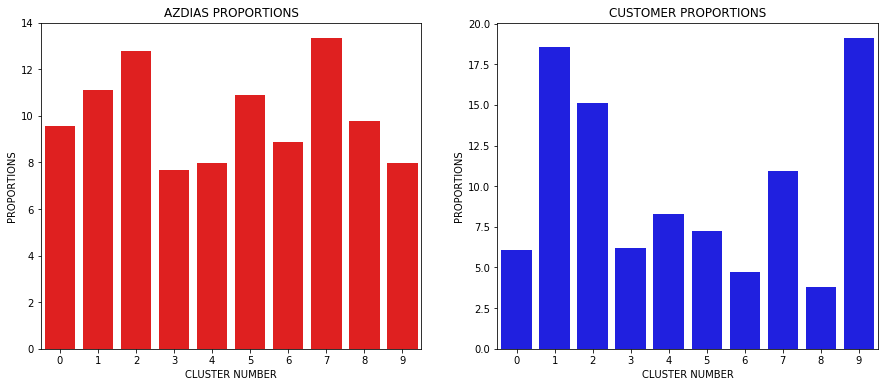

In [58]:
# Compute the proportion of data points in each cluster for the general population
# and the customer data.
azdias_prop = np.unique(azdias_predict, return_counts=True)[1]/ len(azdias_predict)*100
customer_prop =  np.unique(customers_predict, return_counts=True)[1] / len(customers_predict)*100

fig, ax = plt.subplots(nrows=1, ncols=2,figsize = (15,6),sharex=True)
plt.xlabel('CLUSTER NUMBER')
plt.ylabel('PROPORTION')
sns.barplot(x = np.arange(0,10,1),y = azdias_prop,ax = ax[0], color = 'r')
ax[0].set_title('AZDIAS PROPORTIONS')
sns.barplot(x = np.arange(0,10,1),y = customer_prop,ax = ax[1], color = 'b')
ax[1].set_title('CUSTOMER PROPORTIONS')

[ax[i].set_xlabel('CLUSTER NUMBER') for i in range(2)]
[ax[i].set_ylabel('PROPORTIONS') for i in range(2)]

plt.show()


In [59]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
cluster_1 = pipe.named_steps.scaler.inverse_transform(pca_redo.inverse_transform(algorithm.cluster_centers_[1]))
cluster_1_series = pd.Series(cluster_1,customers_clean.columns)

In [60]:
cluster_1_series

ALTERSKATEGORIE_GROB        3.867312
ANREDE_KZ                   0.933103
FINANZ_MINIMALIST           5.235651
FINANZ_SPARER               0.921258
FINANZ_VORSORGER            5.018707
FINANZ_ANLEGER              1.207430
FINANZ_UNAUFFAELLIGER       1.285534
FINANZ_HAUSBAUER            1.969787
GREEN_AVANTGARDE            0.294587
HEALTH_TYP                  2.195917
NATIONALITAET_KZ            0.983227
RETOURTYP_BK_S              4.335928
SEMIO_SOZ                   4.958348
SEMIO_FAM                   4.410638
SEMIO_REL                   2.959690
SEMIO_MAT                   3.064319
SEMIO_VERT                  6.490962
SEMIO_LUST                  5.960935
SEMIO_ERL                   4.670146
SEMIO_KULT                  4.541599
SEMIO_RAT                   1.829689
SEMIO_KRIT                  3.054966
SEMIO_DOM                   2.868618
SEMIO_KAEM                  2.011551
SEMIO_PFLICHT               2.348326
SEMIO_TRADV                 2.218173
SHOPPER_TYP                 1.216412
S

In [61]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
cluster_4 = pipe.named_steps.scaler.inverse_transform(pca_redo.inverse_transform(algorithm.cluster_centers_[4]))
cluster_4_series = pd.Series(cluster_4,customers_clean.columns)


In [62]:
cluster_4_series

ALTERSKATEGORIE_GROB        2.892755
ANREDE_KZ                   0.803815
FINANZ_MINIMALIST           4.278144
FINANZ_SPARER               2.175656
FINANZ_VORSORGER            3.800131
FINANZ_ANLEGER              2.292223
FINANZ_UNAUFFAELLIGER       2.735186
FINANZ_HAUSBAUER            1.940161
GREEN_AVANTGARDE            0.635515
HEALTH_TYP                  2.028921
NATIONALITAET_KZ            1.072133
RETOURTYP_BK_S              3.060629
SEMIO_SOZ                   5.974699
SEMIO_FAM                   5.925612
SEMIO_REL                   4.922757
SEMIO_MAT                   4.800371
SEMIO_VERT                  6.963919
SEMIO_LUST                  4.700083
SEMIO_ERL                   2.554887
SEMIO_KULT                  6.330877
SEMIO_RAT                   3.135448
SEMIO_KRIT                  1.888708
SEMIO_DOM                   2.382872
SEMIO_KAEM                  1.346197
SEMIO_PFLICHT               4.068081
SEMIO_TRADV                 3.950581
SHOPPER_TYP                 0.796289
S

### Discussion 3.3: Compare Customer Data to Demographics Data

Cluster 1 had the most over represented customer type. The customers that were more popular with the mail-order company tended toward the following descriptions:
   - 46-60 age range
   - tended to be more active in investing
   - high in money saving category
   - conservative shoppers
   - slightly less family minded
   - high affinity for religion
   - high affinity for materialistic behavior
   - event oriented, average to low affinity 
   - very traditional minded

The under represented customer type seemed most prevalent in cluster 4.  The customers that were not utilizing the the services of the mail-order company as much tended toward the following descriptions:
   - over the age of 60
   - shopper type is incentive receptive
   - low affinity for religion
   - low affinity for materialistic behavior
   - event oriented, very high to high affinity 
   - not very cultural minded (very low)
   - average tradition minded
   
Knowing what groups are over represented helps to determine target demographic and population type for future marketing. However, knowing what part of the population is under represented will help the mail-order sales company determine whether they should explore ways to expand into this possible untapped market. 




> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.